In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Carregar os arquivos .h5
rotation_train = h5py.File('Rotation(Distance)\TrainRotation(Distance).h5', 'r')
rotation_test = h5py.File('Rotation(Distance)\TestRotation(Distance).h5', 'r')

translation_train = h5py.File('Translation(Angle))\TrainTranslation(Angle).h5', 'r')
translation_test = h5py.File('Translation(Angle))\TestTranslation(Angle).h5', 'r')

# Acessar os dados de treinamento e teste
x_rotation_train = rotation_train['xtrain']
y_rotation_train = rotation_train['ytrain']
x_rotation_test = rotation_test['xtest']
y_rotation_test = rotation_test['ytest']

x_translation_train = translation_train['xtrain']
y_translation_train = translation_train['ytrain']
x_translation_test = translation_test['xtest']
y_translation_test = translation_test['ytest']

In [3]:
print(x_translation_train.shape)

(21000, 3, 180, 320)


In [42]:
print(y_rotation_train[0:1000])

[0.8025     0.46916667 0.74       0.2525     0.23666667 0.80583333
 0.19583333 0.21       0.50833333 0.2625     0.76416667 0.18833333
 0.87833333 0.51083333 0.4975     0.18833333 0.78916667 0.18833333
 0.13916667 0.87833333 0.80583333 0.80333333 0.79       0.2075
 0.79083333 0.12166667 0.2575     0.78083333 0.7975     0.53
 0.505      0.51333333 0.77083333 0.18666667 0.25083333 0.775
 0.50916667 0.25083333 0.80583333 0.77083333 0.18083333 0.54833333
 0.18833333 0.86666667 0.75166667 0.77916667 0.2        0.515
 0.7725     0.1825     0.50416667 0.79083333 0.235      0.87083333
 0.81083333 0.5175     0.49166667 0.5175     0.45166667 0.78166667
 0.51333333 0.51083333 0.49916667 0.80583333 0.49833333 0.49666667
 0.48583333 0.81666667 0.48166667 0.18833333 0.50083333 0.25083333
 0.49916667 0.75333333 0.8375     0.2025     0.21       0.74416667
 0.19416667 0.84166667 0.785      0.515      0.50916667 0.50166667
 0.52166667 0.50916667 0.21916667 0.4975     0.49583333 0.8225
 0.8275     0.19   

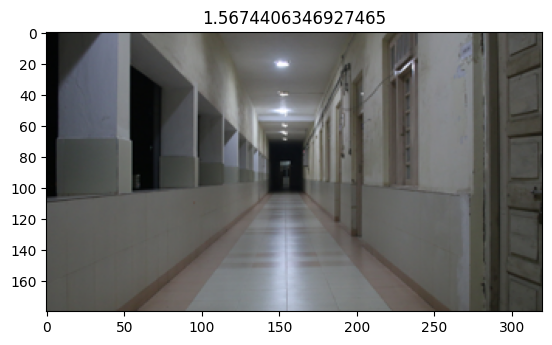

In [8]:
# Acessar a primeira imagem
first_image = x_translation_train[0]

# Transpor a imagem para ter os canais de cor no último eixo
first_image_transposed = np.transpose(first_image, (1, 2, 0))

# Exibir a imagem
plt.imshow(first_image_transposed)
plt.title(y_translation_train[0])
plt.show()


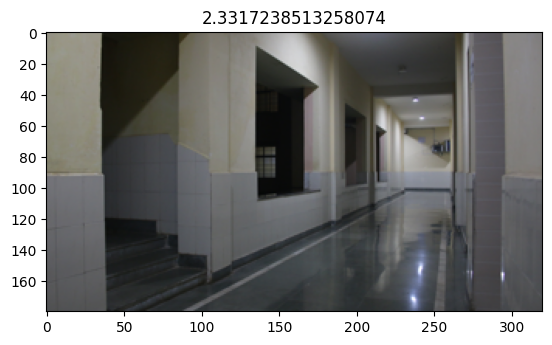

In [11]:
# Acessar a 12a imagem
first_image = x_translation_train[12]

# Transpor a imagem para ter os canais de cor no último eixo
first_image_transposed = np.transpose(first_image, (1, 2, 0))

# Exibir a imagem
plt.imshow(first_image_transposed)
plt.title(y_translation_train[12])
plt.show()


In [50]:
import h5py
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

In [51]:
class CustomDataset(Dataset):
    def __init__(self, h5_file, transform=None):
        self.file = h5py.File(h5_file, 'r')
        if 'Test' in h5_file:
            self.x_data = self.file['xtest'][:1000]
            self.y_data = self.file['ytest'][:1000]
        else:
            self.x_data = self.file['xtrain'][:1000]
            self.y_data = self.file['ytrain'][:1000]
        self.transform = transform
    
    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, idx):
        image = self.x_data[idx]
        label = self.y_data[idx]

        # Transpor para (channels, height, width)
        image = np.transpose(image, (1, 2, 0))

        # Converter o label de contínuo para binário
        label = 1 if label >= 0.4 else 0

        if self.transform:
            image = self.transform(image)
        
        return image, label


# Definir transformações para normalizar as imagens
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Caminho para os arquivos
train_file = 'Rotation(Distance)\TrainRotation(Distance).h5'
test_file = 'Rotation(Distance)\TestRotation(Distance).h5'

# Carregar os datasets
train_dataset = CustomDataset(train_file, transform=transform)
test_dataset = CustomDataset(test_file, transform=transform)

# Dividir os dados de treino em treino e validação
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Criar os DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [52]:
# Definir uma versão simplificada da VGG
class SimpleVGG(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleVGG, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 22 * 40, 256),  # Ajustar se necessário para o tamanho da entrada
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Verificar se CUDA está disponível e mover o modelo para GPU se possível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleVGG(num_classes=2).to(device)

# Definir loss e optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Função de treino com tqdm
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / len(train_loader))
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
        
        # Validação no final de cada época
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    test_bar = tqdm(test_loader, desc="Testing", leave=False)
    
    with torch.no_grad():
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
# Função para avaliar no dataset de teste e medir o tempo de inferência
def evaluate_and_measure_inference_time(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    inference_times = []
    test_bar = tqdm(test_loader, desc="Testing", leave=False)
    
    with torch.no_grad():
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Medir o tempo de inferência
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            # Calcular o tempo de inferência para o lote atual
            inference_time = end_time - start_time
            inference_times.append(inference_time)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_inference_time = sum(inference_times) / len(inference_times)
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
    print(f'Average Inference Time per Batch: {avg_inference_time:.6f} seconds')


In [53]:
# Treinar o modelo
num_epochs = 10
train(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch [1/10], Loss: 0.7001


Validation Loss: 0.6379, Accuracy: 67.50%


Epoch [2/10], Loss: 0.6242


Validation Loss: 0.6376, Accuracy: 67.50%


Epoch [3/10], Loss: 0.6334


Validation Loss: 0.6356, Accuracy: 67.50%


Epoch [4/10], Loss: 0.6041


Validation Loss: 0.5713, Accuracy: 76.00%


Epoch [5/10], Loss: 0.4407


Validation Loss: 0.4206, Accuracy: 85.00%


Epoch [6/10], Loss: 0.2522


Validation Loss: 0.2065, Accuracy: 95.00%


Epoch [7/10], Loss: 0.1646


Validation Loss: 0.1948, Accuracy: 93.00%


Epoch [8/10], Loss: 0.1659


Validation Loss: 0.1131, Accuracy: 96.00%


Epoch [9/10], Loss: 0.0689


Validation Loss: 0.0315, Accuracy: 99.00%


Epoch [10/10], Loss: 0.0337


Validation Loss: 0.0435, Accuracy: 98.50%


In [55]:
# Avaliar no dataset de teste e medir o tempo de inferência
evaluate_and_measure_inference_time(model, test_loader, criterion)

Test Loss: 0.0876, Accuracy: 97.67%
Average Inference Time per Batch: 0.000922 seconds
